# Analysis of electricity market data
---
The notebook describes how the market dataset has been handled. <br>
The dataset is enriched with information about seasons to grasp the different trend of energy price along different periods. <br>
This notebook allows to retrieve also some of the plots presented in the main paper.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style('darkgrid')
sns.set(font_scale=1.5)

In [2]:
plots_dir = 'plots'
os.makedirs(plots_dir, exist_ok=True)

def savefig(fig: plt.Figure, filename: str, **kwargs) -> None:
    save_path = os.path.join(plots_dir, filename)
    fig.savefig(save_path, dpi=300, bbox_inches='tight', **kwargs)

In [3]:
df = pd.read_csv("../../ernestogym/ernesto/data/market/gme_2019-2020_test_new.csv")

In [4]:
df

,bid,timestamp,ask,delta_time
0,0.000051,2019-01-01 00:00:00,0.000138,0.0
1,0.000046,2019-01-01 01:00:00,0.000133,3600.0
2,0.000040,2019-01-01 02:00:00,0.000127,7200.0
3,0.000028,2019-01-01 03:00:00,0.000115,10800.0
4,0.000022,2019-01-01 04:00:00,0.000109,14400.0
...,...,...,...,...
8755,0.000056,2019-12-31 19:00:00,0.000143,31518000.0
8756,0.000053,2019-12-31 20:00:00,0.000140,31521600.0
8757,0.000051,2019-12-31 21:00:00,0.000138,31525200.0
8758,0.000049,2019-12-31 22:00:00,0.000136,31528800.0


In [5]:
df['ask'].mean(), df['bid'].mean()

(0.0001393249387465624, 5.232493874657534e-05)

In [6]:
df = df.drop(columns=['delta_time'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Data to kWh from Wh
#df.loc[:, df.columns != 'timestamp'] /= 1000

<Axes: >

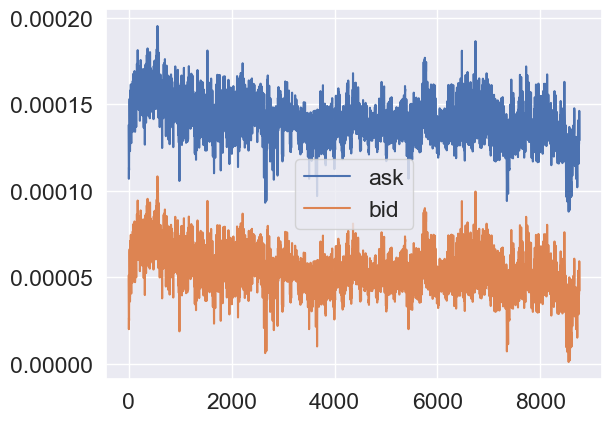

In [7]:
df[['ask', 'bid']].plot()

In [8]:
# Create a Seasonal Dictionary that will map months to seasons
season_dict = {11: 'autumn', 12: 'winter', 1: 'winter', 2: 'winter', 3: 'spring', 4: 'spring', 5: 'spring', 6: 'summer', 7: 'summer', \
8: 'summer', 9: 'autumn', 10: 'autumn'}

In [9]:
df['day'] = df.timestamp.dt.day_of_year
df['month'] = df.timestamp.dt.month
df['season'] = [season_dict[m] for m in df.month]
df

,bid,timestamp,ask,day,month,season
0,0.000051,2019-01-01 00:00:00,0.000138,1,1,winter
1,0.000046,2019-01-01 01:00:00,0.000133,1,1,winter
2,0.000040,2019-01-01 02:00:00,0.000127,1,1,winter
3,0.000028,2019-01-01 03:00:00,0.000115,1,1,winter
4,0.000022,2019-01-01 04:00:00,0.000109,1,1,winter
...,...,...,...,...,...,...
8755,0.000056,2019-12-31 19:00:00,0.000143,365,12,winter
8756,0.000053,2019-12-31 20:00:00,0.000140,365,12,winter
8757,0.000051,2019-12-31 21:00:00,0.000138,365,12,winter
8758,0.000049,2019-12-31 22:00:00,0.000136,365,12,winter


In [10]:
df_winter = df[df['season'] == 'winter'].drop(columns=['season'])
df_summer = df[df['season'] == 'summer'].drop(columns=['season'])

In [11]:
df_mean = []
df_std = []

df_mean.append(df_winter.groupby([df_winter.timestamp.dt.hour]).mean())
df_mean.append(df_summer.groupby([df_summer.timestamp.dt.hour]).mean())

df_std.append(df_winter.groupby([df_winter.timestamp.dt.hour]).std())
df_std.append(df_summer.groupby([df_summer.timestamp.dt.hour]).std())

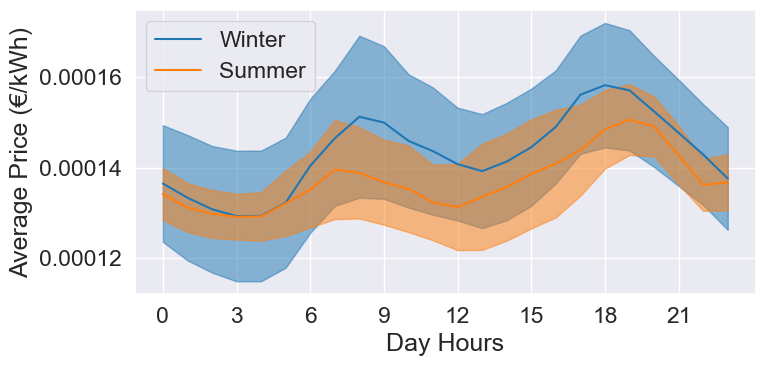

In [12]:
# Plot of DAILY AVERAGE DEMAND in different season of the year
col = 'ask'

fig, ax = plt.subplots( figsize=(8, 4), tight_layout=True, sharey=True)

idx = 0
ax.plot(df_mean[idx].index, df_mean[idx][col], label='Winter', color='tab:blue')
ax.fill_between(df_mean[idx].index, df_mean[idx][col] - df_std[idx][col], df_mean[idx][col] + df_std[idx][col], color='tab:blue', alpha=0.5)

idx = 1
ax.plot(df_mean[idx].index, df_mean[idx][col], label='Summer', color='tab:orange')
ax.fill_between(df_mean[idx].index, df_mean[idx][col] - df_std[idx][col], df_mean[idx][col] + df_std[idx][col], color='tab:orange', alpha=0.5)

ax.set(xlabel='Day Hours', ylabel='Average Price (€/kWh)', xticks=df_mean[idx].index[::3])
ax.legend()

#savefig(fig, filename='winter_summer_market.pdf')
#savefig(fig, filename='winter_summer_market.png')

plt.show()

In [13]:
df_weekly_mean = df.drop(columns=['season']).groupby([df.timestamp.dt.isocalendar().week]).mean()
df_weekly_std = df.drop(columns=['season']).groupby([df.timestamp.dt.isocalendar().week]).std()

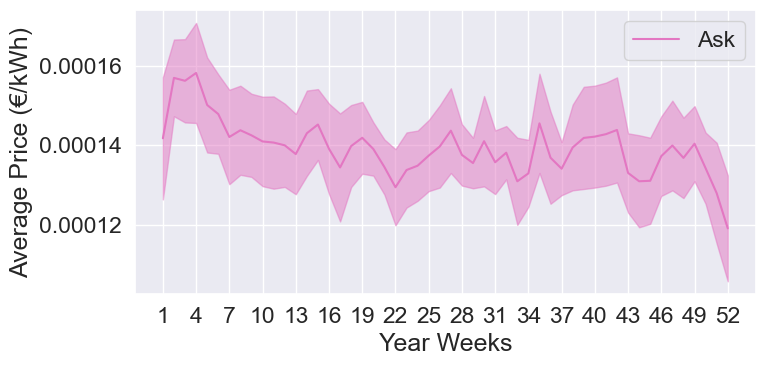

In [14]:
# Plot of AVERAGE DEMAND during the year
col = 'ask'

fig, ax = plt.subplots( figsize=(8, 4), tight_layout=True, sharey=True)

ax.plot(df_weekly_mean.index, df_weekly_mean[col], label='Ask', color='tab:pink')
ax.fill_between(list(df_weekly_std.index), df_weekly_mean[col] - df_weekly_std[col],  df_weekly_mean[col] + df_weekly_std[col], color='tab:pink', alpha=0.5)


ax.set(xlabel='Year Weeks', ylabel='Average Price (€/kWh)', xticks=list(df_weekly_mean.index[::3]))
ax.legend()

#savefig(fig, filename='market_per_year_week.pdf')
#savefig(fig, filename='market_per_year_week.png')

plt.show()